In [1]:
import pandas as pd
import torch.nn as nn
from tbnn.training_utils import early_stopped_tbnnPlus_training_run
import torch
import matplotlib.pyplot as plt
import pickle
import torch.nn as nn
import tbnn.models as models
import tbnn.devices as devices
import tbnn.dataloaders as dataloaders
import tbnn.losses as losses
device = devices.get_device()



In [2]:
dataset_params = {'file': '/home/ryley/WDK/ML/dataset/komegasst_split.csv',
                  'test_set': ['case_1p2'],
                }

df = pd.read_csv(dataset_params['file'])

df = df[df['Case'].isin(['case_1p0', 'case_0p8','case_1p2'])]
df = df.sample(frac=0.3)
df_test = df[df['Case'].isin(dataset_params['test_set'])]
df_tv = df[~df['Case'].isin(dataset_params['test_set'])]
print(f'Dataset: {len(df)}, test: {len(df_test)}, tv: {len(df_tv)}')



Dataset: 13276, test: 4444, tv: 8832


Training points: 4415, validation points 4417
EPOCH    LR        TRAIN     VALID         MSE_b:T/V         MSE_g1:T/V            RL:T/V         %NR_t/%NR_v
  1   1.000e-03   0.00977   0.00927   0.00977 / 0.00927   0.00000 / 0.00000   0.00% / 0.00%
 10   9.928e-04   0.00536   0.00521   0.00536 / 0.00513   0.00000 / 0.00000   0.02% / 0.05%
 20   9.849e-04   0.00443   0.00428   0.00443 / 0.00417   0.00000 / 0.00000   0.02% / 0.05%
 30   9.771e-04   0.00398   0.00395   0.00397 / 0.00376   0.00000 / 0.00000   0.18% / 0.14%
 40   9.693e-04   0.00374   0.00381   0.00373 / 0.00358   0.00000 / 0.00000   0.11% / 0.29%
 50   9.615e-04   0.00360   0.00375   0.00360 / 0.00347   0.00000 / 0.00000   0.16% / 0.27%
 60   9.539e-04   0.00352   0.00346   0.00352 / 0.00342   0.00000 / 0.00000   0.02% / 0.11%
 70   9.463e-04   0.00346   0.00345   0.00346 / 0.00336   0.00000 / 0.00000   0.02% / 0.18%
 80   9.387e-04   0.00343   0.00330   0.00343 / 0.00329   0.00000 / 0.00000   0.00% / 0.07%
 90   9.312e-04 

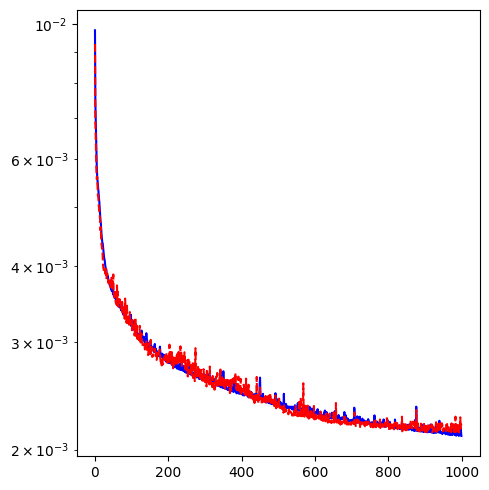

In [6]:
training_params = {'early_stopping_patience': 200,
                    'max_epochs': 1000,
                      'learning_rate': 0.001,
                        'learning_rate_decay': 0.9992,
                          'batch_size': 64,
                            'val_set': ['case_0p8']}

model_params = {'neurons': 20, 'n_hidden': 3, 'activation_function': nn.SiLU(),                 
                #'input_features': ['komegasst_q6','komegasst_q5','komegasst_I1_1','komegasst_I1_3','komegasst_I2_3','komegasst_I1_5']
                'input_features':['komegasst_I1_1',
'komegasst_I1_3',
'komegasst_I1_4',
'komegasst_I1_5',
#'komegasst_I1_16',
#'komegasst_I1_7',
#'komegasst_I1_9',
#'komegasst_I1_10',
#'komegasst_I1_12',
#'komegasst_I1_13',
#'komegasst_I1_16',
'komegasst_q5',
#'komegasst_q6',
]
}

model = models.TBNNPlus(N = 10,
                input_dim = len(model_params['input_features']),
                n_hidden = model_params['n_hidden'],
                neurons = model_params['neurons'],
                activation_function = model_params['activation_function'],
                input_feature_names=model_params['input_features']
            ).to(device)

model, loss_vals, val_loss_vals  = early_stopped_tbnnPlus_training_run(model = model,
                                                                   training_params = training_params,
                                                                   df_tv = df_tv)

fig, ax = plt.subplots(1,figsize=(5,5))
ax.plot(loss_vals,'-',color='b')
ax.plot(val_loss_vals,'--',color='r')
ax.semilogy()
fig.tight_layout()
#fig.savefig(f'models/model_cluster_{cluster}.png',dpi=300)

In [7]:
import tbnn.training_utils as training_utils
import numpy as np
from torch.utils.data import Dataset, DataLoader

df_train = df[~df['Case'].isin(dataset_params['test_set']+training_params['val_set'])]
#df_test = df[df['Case'].isin(test_set)].copy()


df_test[f'pred_b_11_all'] = np.zeros(len(df_test))
df_test[f'pred_b_12_all'] = np.zeros(len(df_test))
df_test[f'pred_b_13_all'] = np.zeros(len(df_test))
df_test[f'pred_b_22_all'] = np.zeros(len(df_test))
df_test[f'pred_b_23_all'] = np.zeros(len(df_test))
df_test[f'pred_b_33_all'] = np.zeros(len(df_test))


#model_params = pickle.load(open(f"models/params_cluster_all.pickle", "rb"))
#df_train_i = df_train[df_train['Cluster'] == cluster]
#df_test_i = df_test[df_test['Cluster'] == cluster].copy()

tDs = dataloaders.bDatasetPlus(df_train, input_features=model_params['input_features'])
testDs = dataloaders.bDatasetPlus(df_test, input_features=model_params['input_features'],scaler_X = tDs.scaler_X)

model.eval()
for X, T, y, g1tilde in DataLoader(testDs, shuffle=False, batch_size=testDs.__len__()):
    y_pred_test, gn = model(X,T)
    #print(f"loss: {losses.bLoss(y_pred_test,y)}")
    #print(f"loss: {losses.mseLoss(y_pred_test,y)}")
    #print(f"loss: {losses.realizabilityPenalty(y)}")
    #print(f"loss: {losses.realizabilityPenalty_components(y)}")
    #print(f"loss: {losses.realizabilityPenalty_eigs(y)}")


    #val_loss_values.append(loss_fn(y_pred_val,y).item())   
    #mse_v = mseLoss(y_pred_val,y).item()  
    #rl_v = realizLoss(y_pred_val,y).item()
#for prediction_name in ['pred_b_11','pred_b_12','pred_b_13','pred_b_22','pred_b_23','pred_b_33']:
#print(y_pred_test.shape)
df_test[f'pred_b_11_all'] = y_pred_test[:,0,0].detach().numpy()
df_test[f'pred_b_12_all'] = y_pred_test.detach().numpy()[:,0,1]
df_test[f'pred_b_13_all'] = y_pred_test.detach().numpy()[:,0,2]
df_test[f'pred_b_22_all'] = y_pred_test.detach().numpy()[:,1,1]
df_test[f'pred_b_23_all'] = y_pred_test.detach().numpy()[:,1,2]
df_test[f'pred_b_33_all'] = y_pred_test.detach().numpy()[:,2,2]

df_test[f'pred_g1'] = gn[:,0].detach().numpy()
df_test[f'pred_g2'] = gn[:,1].detach().numpy()
df_test[f'pred_g3'] = gn[:,2].detach().numpy()
df_test[f'pred_g4'] = gn[:,3].detach().numpy()
df_test[f'pred_g5'] = gn[:,4].detach().numpy()
df_test[f'pred_g6'] = gn[:,5].detach().numpy()
df_test[f'pred_g7'] = gn[:,6].detach().numpy()
df_test[f'pred_g8'] = gn[:,7].detach().numpy()
df_test[f'pred_g9'] = gn[:,8].detach().numpy()
df_test[f'pred_g10'] = gn[:,9].detach().numpy()
df_test[f'labels_scaled_g1tilde'] = g1tilde #tDs.scaler_g1tilde.inverse_transform(g1tilde.detach().numpy().reshape(-1, 1))
df_test[f'pred_g1tilde'] = np.log(-gn[:,0].detach().numpy())#tDs.scaler_g1tilde.inverse_transform(np.exp(-gn[:,0].detach().numpy()).reshape(-1, 1))




/tmp/ipykernel_50243/208228390.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f'pred_b_11_all'] = np.zeros(len(df_test))
/tmp/ipykernel_50243/208228390.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f'pred_b_12_all'] = np.zeros(len(df_test))
/tmp/ipykernel_50243/208228390.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

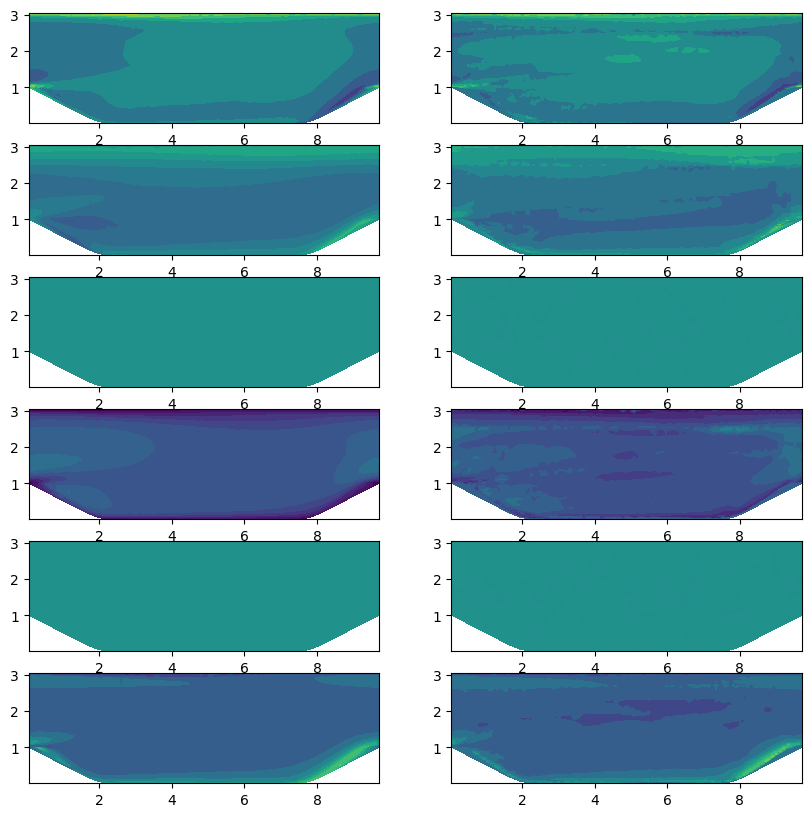

In [8]:
fig, axs = plt.subplots(nrows=6,ncols=2,figsize=(10,10))
axs[0,0].tricontourf(df_test['komegasst_C_1'],df_test['komegasst_C_2'],df_test['DNS_b_11'],vmin=-1/3,vmax=2/3)
axs[0,1].tricontourf(df_test['komegasst_C_1'],df_test['komegasst_C_2'],df_test['pred_b_11_all'],vmin=-1/3,vmax=2/3)

axs[1,0].tricontourf(df_test['komegasst_C_1'],df_test['komegasst_C_2'],df_test['DNS_b_12'],vmin=-1/2,vmax=1/2)
axs[1,1].tricontourf(df_test['komegasst_C_1'],df_test['komegasst_C_2'],df_test['pred_b_12_all'],vmin=-1/2,vmax=1/2)

axs[2,0].tricontourf(df_test['komegasst_C_1'],df_test['komegasst_C_2'],df_test['DNS_b_13'],vmin=-1/2,vmax=1/2)
axs[2,1].tricontourf(df_test['komegasst_C_1'],df_test['komegasst_C_2'],df_test['pred_b_13_all'],vmin=-1/2,vmax=1/2)

axs[3,0].tricontourf(df_test['komegasst_C_1'],df_test['komegasst_C_2'],df_test['DNS_b_22'],vmin=-1/3,vmax=2/3)
axs[3,1].tricontourf(df_test['komegasst_C_1'],df_test['komegasst_C_2'],df_test['pred_b_22_all'],vmin=-1/3,vmax=2/3)

axs[4,0].tricontourf(df_test['komegasst_C_1'],df_test['komegasst_C_2'],df_test['DNS_b_23'],vmin=-1/2,vmax=1/2)
axs[4,1].tricontourf(df_test['komegasst_C_1'],df_test['komegasst_C_2'],df_test['pred_b_23_all'],vmin=-1/2,vmax=1/2)

axs[5,0].tricontourf(df_test['komegasst_C_1'],df_test['komegasst_C_2'],df_test['DNS_b_33'],vmin=-1/3,vmax=2/3)
axs[5,1].tricontourf(df_test['komegasst_C_1'],df_test['komegasst_C_2'],df_test['pred_b_33_all'],vmin=-1/3,vmax=2/3)

for ax in axs.reshape(-1): 
    ax.set_aspect(1)


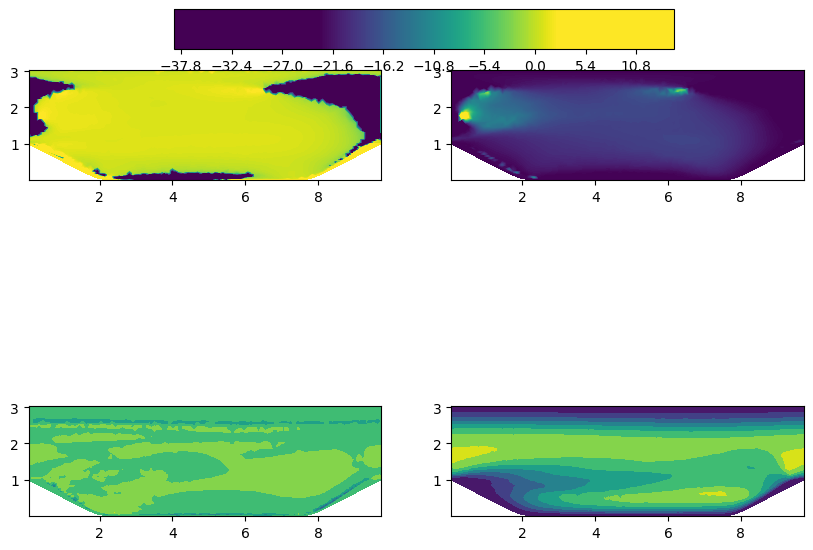

In [40]:
fig, axs = plt.subplots(nrows=2,ncols=2,figsize=(10,8))
tcf1 = axs[0,0].tricontourf(df_test['komegasst_C_1'],df_test['komegasst_C_2'],df_test['DNS_g1tilde'],300,vmin=np.log(1E-10), vmax = np.log(10))
axs[1,0].tricontourf(df_test['komegasst_C_1'],df_test['komegasst_C_2'],df_test['pred_g1tilde'])
tcf2 = axs[0,1].tricontourf(df_test['komegasst_C_1'],df_test['komegasst_C_2'],df_test['DNS_nut_nnls'],300,vmin=0.1*min(df_test['komegasst_nut']), vmax=10*max(df_test['komegasst_nut']))
axs[1,1].tricontourf(df_test['komegasst_C_1'],df_test['komegasst_C_2'],df_test['komegasst_nut'])

for ax in axs.reshape(-1): 
    ax.set_aspect(1)
cax = fig.add_axes([0.27, 0.8, 0.5, 0.05])
fig.colorbar(tcf1, cax=cax, orientation='horizontal')